In [252]:
import ctd
import pandas as pd

# science stack
import numpy as np
from scipy import interpolate

import seawater as sw
# Visual Stack

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


### Load Seabird CTD Calibration Cast

In [253]:
f = '/Users/bell/ecoraid/2019/CTDcasts/dy1904/rawconverted/ctd051.cnv'

In [254]:
ctd_df = ctd.from_cnv(f)

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ctd/ctd.py:147: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.header = header
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ctd/ctd.py:149: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.config = config


In [255]:
ctd_df.describe()

,c0mS/cm,c1mS/cm,flECO-AFL,sbeox0V,t090C,t190C,timeS,sbeox1V,par,turbWETntu0,...,sal11,sigma-t00,sigma-t11,sbeox0ML/L,sbox0Mm/Kg,sbeox0PS,sbeox1ML/L,sbox1Mm/Kg,sbeox1PS,nbin
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,29.993529,29.996034,2.774989,2.620668,4.011783,4.013214,156.932585,2.603822,2.798474,0.546466,...,31.936725,25.346677,25.347766,8.189674,356.710231,110.815092,7.802940,339.865323,105.587031,36.815385
std,0.320090,0.320637,2.790815,0.138153,0.412654,0.413166,36.529158,0.137760,8.399856,0.126338,...,0.018076,0.055127,0.055060,0.418074,18.229402,6.796210,0.398667,17.382677,6.480660,12.770685
min,29.762488,29.764085,0.667200,2.515300,3.714800,3.715400,96.408000,2.499200,0.214300,0.387000,...,31.909300,25.260800,25.262000,7.883300,343.354000,105.949000,7.518000,327.441000,100.956000,11.000000
25%,29.767192,29.768676,0.770200,2.521200,3.715900,3.716500,125.575000,2.504400,0.214480,0.443100,...,31.910800,25.265000,25.266900,7.909300,344.484000,106.222000,7.534100,328.142000,101.171000,28.000000
50%,29.774046,29.775821,0.821500,2.527200,3.722300,3.724700,156.990000,2.512800,0.214580,0.494600,...,31.949800,25.386000,25.386500,7.917400,344.839000,106.328000,7.544600,328.601000,101.341000,37.000000
75%,30.471365,30.473257,6.388400,2.822400,4.623500,4.623300,189.201000,2.804400,0.420180,0.695700,...,31.950800,25.386900,25.388100,8.714300,379.591000,119.592000,8.292300,361.207000,113.802000,45.000000
max,30.495158,30.497048,7.527300,2.835900,4.658900,4.659500,217.467000,2.819300,51.533000,0.802500,...,31.951000,25.387300,25.388400,8.889100,387.205000,122.058000,8.476400,369.228000,116.396000,67.000000


### Load Prawler Profile

Wetlabs needs a linear transformation from counts to sci-units   
Oxygen needs to be corrected for salinity

In [256]:
df = '/Users/bell/Desktop/19bsitaepr2a_new.dat'

In [257]:
ctd_pd = pd.read_csv(df)

In [258]:
ctd_pd.CD = ctd_pd.CD/100
ctd_pd.CT = ctd_pd.CT/1000
ctd_pd.CC = ctd_pd.CC/1000
ctd_pd.OT = ctd_pd.OT/1000
ctd_pd['02'] = ctd_pd['02']/100
ctd_pd.CH = (ctd_pd.CH-50)*0.0122
ctd_pd.TB = (ctd_pd.TB-50)*0.0247

In [259]:
ctd_df.index = ctd_df.index -0

In [260]:
### oxy optode has error in temp probe for 2019 BS deployment - back calculate CalPhase and reapply using sbe temp

## from S.Sneddon excel sheet -> (O2_minus correction), Calc Ksv, Calc P0, Calc Pc, CalcCalPhase
"""SVUFoilCoef = [3.0464200E-03,1.3769600E-04,2.1505300E-06,1.7770200E+02,-2.0317100E-01,-4.1285900E+01,3.4537800E+00]

ctd_pd['02_minuscorr'] = (ctd_pd['02'] - 0.0) / 1.0
ctd_pd['Calc_Ksv'] = SVUFoilCoef[0] + (SVUFoilCoef[1]*ctd_pd.OT) + (SVUFoilCoef[2]*ctd_pd.OT**2)
ctd_pd['Calc_P0'] = SVUFoilCoef[3] + (SVUFoilCoef[4]*ctd_pd.OT)
ctd_pd['Calc_Pc'] = ctd_pd['Calc_P0']/(ctd_pd['Calc_Ksv']*ctd_pd['02_minuscorr']+1)
ctd_pd['CalcCalPhase'] = (ctd_pd['Calc_Pc'] - SVUFoilCoef[5])/SVUFoilCoef[6]

### Now calculate with SBE temp
ctd_pd['SBETcorr_O2'] = (((SVUFoilCoef[3] + SVUFoilCoef[4]*ctd_pd.CT)/(SVUFoilCoef[5]+SVUFoilCoef[6]*ctd_pd['CalcCalPhase'])-1)/ \
                         (SVUFoilCoef[0] + SVUFoilCoef[1]*ctd_pd.CT + SVUFoilCoef[2]*ctd_pd.CT**2))*1 + 0.0"""

"SVUFoilCoef = [3.0464200E-03,1.3769600E-04,2.1505300E-06,1.7770200E+02,-2.0317100E-01,-4.1285900E+01,3.4537800E+00]\n\nctd_pd['02_minuscorr'] = (ctd_pd['02'] - 0.0) / 1.0\nctd_pd['Calc_Ksv'] = SVUFoilCoef[0] + (SVUFoilCoef[1]*ctd_pd.OT) + (SVUFoilCoef[2]*ctd_pd.OT**2)\nctd_pd['Calc_P0'] = SVUFoilCoef[3] + (SVUFoilCoef[4]*ctd_pd.OT)\nctd_pd['Calc_Pc'] = ctd_pd['Calc_P0']/(ctd_pd['Calc_Ksv']*ctd_pd['02_minuscorr']+1)\nctd_pd['CalcCalPhase'] = (ctd_pd['Calc_Pc'] - SVUFoilCoef[5])/SVUFoilCoef[6]\n\n### Now calculate with SBE temp\nctd_pd['SBETcorr_O2'] = (((SVUFoilCoef[3] + SVUFoilCoef[4]*ctd_pd.CT)/(SVUFoilCoef[5]+SVUFoilCoef[6]*ctd_pd['CalcCalPhase'])-1)/                          (SVUFoilCoef[0] + SVUFoilCoef[1]*ctd_pd.CT + SVUFoilCoef[2]*ctd_pd.CT**2))*1 + 0.0"

In [261]:
#grid to 1m bins to be consistent with seabird data
#depth_grid = np.arange(5,67)
#interpolate.interp1d(depth_grid,ctd_pd.CD,ctd_pd['02'])

# convert cond to salinity
ctd_pd.S = sw.salt(r=ctd_pd.CC/42.914,t=ctd_pd.CT,p=ctd_pd.CD)

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [262]:
import calc.aanderaa_corrO2_sal as optode_O2_corr

In [263]:
ctd_pd['O2_corr'] = optode_O2_corr.O2_sal_comp(oxygen_conc=ctd_pd['02'],
                                     salinity=ctd_pd.S,
                                     temperature=ctd_pd.CT)
ctd_pd['O2_corr_umkg'] = optode_O2_corr.O2_molar2umkg(oxygen_conc=ctd_pd.O2_corr,
                                     salinity=ctd_pd.S,
                                     temperature=ctd_pd.CT,
                                     pressure=ctd_pd.CD)

ctd_pd['O2PercentSat'] = optode_O2_corr.O2PercentSat(oxygen_conc=ctd_pd.O2_corr_umkg,
                                     salinity=ctd_pd.S,
                                     temperature=ctd_pd.CT,
                                     pressure=ctd_pd.CD)

In [264]:
class CTDProfilePlot(object):


    def __init__(self, fontsize=10, labelsize=10, plotstyle='k-.', stylesheet='seaborn-ticks'):
        """Initialize the timeseries with items that do not change.

        This sets up the axes and station locations. The `fontsize` and `spacing`
        are also specified here to ensure that they are consistent between individual
        station elements.

        Parameters
        ----------
        fontsize : int
            The fontsize to use for drawing text
        labelsize : int
          The fontsize to use for labels
        stylesheet : str
          Choose a mpl stylesheet [u'seaborn-darkgrid', 
          u'seaborn-notebook', u'classic', u'seaborn-ticks', 
          u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', 
          u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', 
          u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', 
          u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', 
          u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', 
          u'seaborn-dark-palette']
        """

        self.fontsize = fontsize
        self.labelsize = labelsize
        self.plotstyle = plotstyle
        self.max_xticks = 10
        plt.style.use(stylesheet)
        mpl.rcParams['svg.fonttype'] = 'none'
        mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
        mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
        mpl.rcParams['axes.grid'] = True
        mpl.rcParams['axes.edgecolor'] = 'white'
        mpl.rcParams['axes.linewidth'] = 0.25
        mpl.rcParams['grid.linestyle'] = '--'
        mpl.rcParams['grid.linestyle'] = '--'
        mpl.rcParams['xtick.major.size'] = 2
        mpl.rcParams['xtick.minor.size'] = 1
        mpl.rcParams['xtick.major.width'] = 0.25
        mpl.rcParams['xtick.minor.width'] = 0.25
        mpl.rcParams['ytick.major.size'] = 2
        mpl.rcParams['ytick.minor.size'] = 1
        mpl.rcParams['xtick.major.width'] = 0.25
        mpl.rcParams['xtick.minor.width'] = 0.25
        mpl.rcParams['ytick.direction'] = 'out'
        mpl.rcParams['xtick.direction'] = 'out'
        mpl.rcParams['ytick.color'] = 'grey'
        mpl.rcParams['xtick.color'] = 'grey'
        
    def plot2var(self, epic_key=None, xdata=None, ydata=None, xlabel=None, secondary=False, **kwargs):
      fig = plt.figure(1)
      ax1 = fig.add_subplot(111)
      p1 = ax1.plot(xdata[0], ydata[0])
      plt.setp(p1, color=self.var2format(epic_key[0])['color'],
                   linestyle=self.var2format(epic_key[0])['linestyle'],
                   linewidth=self.var2format(epic_key[0])['linewidth'])
      if secondary and not (xdata[1].size == 0):
        p1 = ax1.plot(xdata[1],ydata[1])
        plt.setp(p1, color=self.var2format(epic_key[1])['color'],
                     linestyle=self.var2format(epic_key[1])['linestyle'],
                     linewidth=self.var2format(epic_key[1])['linewidth'])
        #set plot limits for two vars by finding the absolute range and adding 10%
        abmin=np.min([np.nanmin(xdata[0]),np.nanmin(xdata[1])])
        abmax=np.max([np.nanmax(xdata[0]),np.nanmax(xdata[1])])
        ax1.set_xlim([abmin - 0.1*(abmax-abmin),abmax + 0.1*(abmax-abmin)])

      ax1.invert_yaxis()
      plt.ylabel('Depth (dB)', fontsize=self.labelsize, fontweight='bold')
      plt.xlabel(xlabel[0], fontsize=self.labelsize, fontweight='bold')
    
      fmt=mpl.ticker.StrMethodFormatter(self.var2format(epic_key[0])['format'])
      ax1.xaxis.set_major_formatter(fmt)
      ax1.tick_params(axis='both', which='major', labelsize=self.labelsize)

      #plot second param
      ax2 = ax1.twiny()
      p1 = ax2.plot(xdata[2], ydata[0])
      plt.setp(p1, color=self.var2format(epic_key[2])['color'],
                   linestyle=self.var2format(epic_key[2])['linestyle'],
                   linewidth=self.var2format(epic_key[2])['linewidth'])
      if secondary and not (xdata[3].size == 0):
        p1 = ax2.plot(xdata[3],ydata[1])
        plt.setp(p1, color=self.var2format(epic_key[3])['color'],
                     linestyle=self.var2format(epic_key[3])['linestyle'],
                     linewidth=self.var2format(epic_key[3])['linewidth'])
        #set plot limits for two vars by finding the absolute range and adding 10%
        abmin=np.min([np.nanmin(xdata[2]),np.nanmin(xdata[3])])
        abmax=np.max([np.nanmax(xdata[2]),np.nanmax(xdata[3])])
        try:
          ax2.set_xlim([abmin - 0.1*(abmax-abmin),abmax + 0.1*(abmax-abmin)])
        except:
          ax2.set_xlim([0,1])

      plt.ylabel('Depth (dB)', fontsize=self.labelsize, fontweight='bold')
      plt.xlabel(xlabel[1], fontsize=self.labelsize, fontweight='bold')

      #set xticks and labels to be at the same spot for all three vars
      ax1.set_xticks(np.linspace(ax1.get_xbound()[0], ax1.get_xbound()[1], self.max_xticks))
      ax2.set_xticks(np.linspace(ax2.get_xbound()[0], ax2.get_xbound()[1], self.max_xticks))

      fmt=mpl.ticker.StrMethodFormatter(self.var2format(epic_key[2])['format'])
      ax2.xaxis.set_major_formatter(fmt)
      ax2.tick_params(axis='x', which='major', labelsize=self.labelsize)


      return plt, fig

    def plot3var(self, epic_key=None, xdata=None, ydata=None, xlabel=None, **kwargs):
        fig = plt.figure(1)
        ax1 = fig.add_subplot(111)
        p1 = ax1.plot(xdata[0], ydata[0])
        plt.setp(p1, color=self.var2format(epic_key[0])['color'],
                   linestyle=self.var2format(epic_key[0])['linestyle'],
                   linewidth=self.var2format(epic_key[0])['linewidth'])
        p1 = ax1.plot(xdata[1],ydata[1])
        plt.setp(p1, color=self.var2format(epic_key[1])['color'],
                     linestyle=self.var2format(epic_key[1])['linestyle'],
                     linewidth=self.var2format(epic_key[1])['linewidth'])
        #set plot limits for two vars by finding the absolute range and adding 10%
        p1 = ax1.plot(xdata[2],ydata[2])
        plt.setp(p1, color=self.var2format(epic_key[2])['color'],
                     linestyle=self.var2format(epic_key[2])['linestyle'],
                     linewidth=self.var2format(epic_key[2])['linewidth'])
        #set plot limits for two vars by finding the absolute range and adding 10%
        abmin=np.min([np.nanmin(xdata[0]),np.nanmin(xdata[1]),np.nanmin(xdata[2])])
        abmax=np.max([np.nanmax(xdata[0]),np.nanmax(xdata[1]),np.nanmax(xdata[2])])
        ax1.set_xlim([abmin - 0.1*(abmax-abmin),abmax + 0.1*(abmax-abmin)])

        ax1.invert_yaxis()
        plt.ylabel('Depth (dB)', fontsize=self.labelsize, fontweight='bold')
        plt.xlabel(xlabel[0], fontsize=self.labelsize, fontweight='bold')

        fmt=mpl.ticker.StrMethodFormatter(self.var2format(epic_key[0])['format'])
        ax1.xaxis.set_major_formatter(fmt)
        ax1.tick_params(axis='both', which='major', labelsize=self.labelsize)


        return plt, fig

    @staticmethod
    def var2format(epic_key):
      """list of plot specifics based on variable name"""
      plotdic={}
      if epic_key in ['T_28']:
        plotdic['color']='red'
        plotdic['linestyle']='-'
        plotdic['linewidth']=0.5
        plotdic['format']='{x:.3f}'
      elif epic_key in ['T2_35']:
        plotdic['color']='magenta'
        plotdic['linestyle']='--'
        plotdic['linewidth']=0.5
        plotdic['format']='{x:.3f}'
      elif epic_key in ['S_41', 'OST_62', 'O_65']:
        plotdic['color']='blue'
        plotdic['linestyle']='-'
        plotdic['linewidth']=0.5
        if epic_key in ['S_41']:
          plotdic['format']='{x:.3f}'
        else:
          plotdic['format']='{x:3.1f}'
      elif epic_key in ['S_42', 'CTDOST_4220', 'CTDOXY_4221']:
        plotdic['color']='cyan'
        plotdic['linestyle']='--'
        plotdic['linewidth']=0.5
        plotdic['format']='{x:3.1f}'
        if epic_key in ['S_42']:
          plotdic['format']='{x:.3f}'
        else:
          plotdic['format']='{x:3.1f}'
      elif epic_key in ['ST_70','Trb_980','SigmaT']:
        plotdic['color']='black'
        plotdic['linestyle']='-'
        plotdic['linewidth']=0.5
        plotdic['format']='{x:.3f}'
      elif epic_key in ['F_903','fWS_973','Fch_906']:
        plotdic['color']='green'
        plotdic['linestyle']='-'
        plotdic['linewidth']=0.5
        plotdic['format']='{x:.2f}'
      elif epic_key in ['PAR_905']:
        plotdic['color']='darkorange'
        plotdic['linestyle']='-'
        plotdic['linewidth']=0.75
        plotdic['format']='{x:5.0f}'
      elif epic_key in ['blank']:
        plotdic['color']='black'
        plotdic['linestyle']='--'
        plotdic['linewidth']=0.0      
        plotdic['format']='{x:.3f}'
      else:
        plotdic['color']='black'
        plotdic['linestyle']='--'
        plotdic['linewidth']=1.0      
        plotdic['format']='{x:.3f}'

      return plotdic

    @staticmethod
    #python3 change as dictionaries no longer have itervalues methods
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)

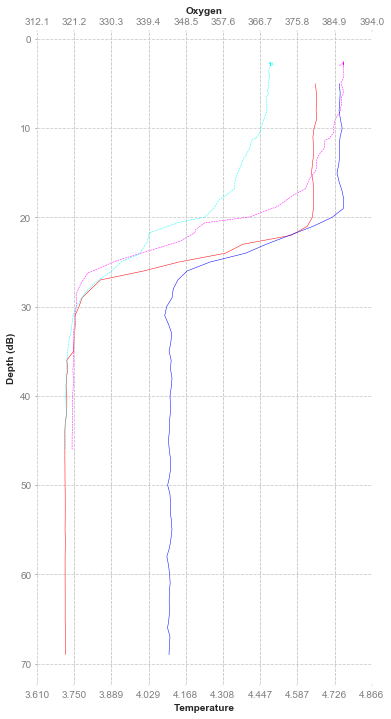

In [265]:
ctd_data = CTDProfilePlot()
plt,fig =ctd_data.plot2var(epic_key=['T_28','T2_35','O_65','CTDOXY_4221'],
                  xdata=[ctd_df.t090C,ctd_pd.CT,ctd_df['sbox0Mm/Kg'],ctd_pd.O2_corr_umkg],
                  ydata=[ctd_df.index,ctd_pd.CD],
                  secondary=True,
                  xlabel=['Temperature','Oxygen'])

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
plt.savefig(f.split('/')[-1].replace('.cnv','_TempOxy_CTDvPrawler.png'))

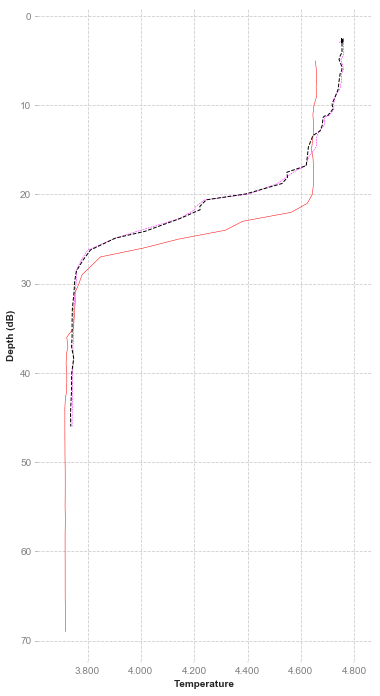

In [266]:
plt,fig =ctd_data.plot3var(epic_key=['T_28','T2_35',''],
                  xdata=[ctd_df.t090C,ctd_pd.CT,ctd_pd.OT],
                  ydata=[ctd_df.index,ctd_pd.CD,ctd_pd.CD],
                  secondary=True,
                  xlabel=['Temperature'])

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
plt.savefig(f.split('/')[-1].replace('.cnv','_TempTemp_CTDvPrawler.png'))

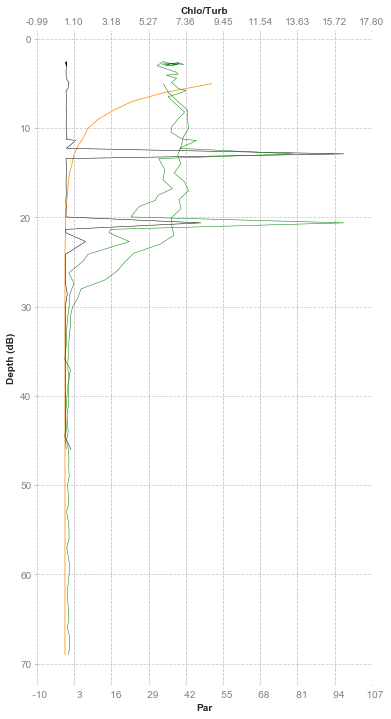

In [267]:
plt,fig =ctd_data.plot2var(epic_key=['PAR_905','Trb_980','Fch_906','Fch_906'],
                  xdata=[ctd_df.par,ctd_pd.TB,ctd_df['flECO-AFL'],ctd_pd.CH],
                  ydata=[ctd_df.index,ctd_pd.CD],
                  secondary=True,
                  xlabel=['Par','Chlo/Turb'])

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
plt.savefig(f.split('/')[-1].replace('.cnv','_ParChlorTurb.png'))

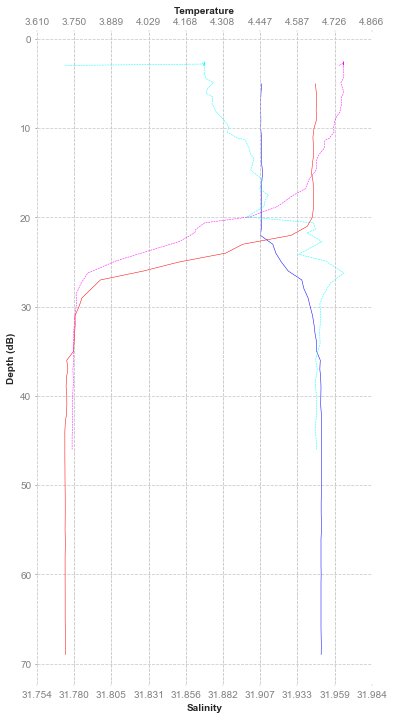

In [268]:
plt,fig =ctd_data.plot2var(epic_key=['S_41','S_42','T_28','T2_35'],
                  xdata=[ctd_df.sal00,ctd_pd.S,ctd_df.t090C,ctd_pd.CT],
                  ydata=[ctd_df.index,ctd_pd.CD],
                  secondary=True,
                  xlabel=['Salinity','Temperature'])

DefaultSize = fig.get_size_inches()
fig.set_size_inches( (DefaultSize[0], DefaultSize[1]*3) )
plt.savefig(f.split('/')[-1].replace('.cnv','_TempSal.png'))